In [1]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("E-Shop Analysis") \
    .getOrCreate()

# Read data into DataFrame
df = spark.read.csv("/home/jovyan/e-shop clothing 2008.csv", header=True,  sep=";")

In [2]:
pwd

'/home/jovyan'

In [3]:
# Show schema of DataFrame
df.printSchema()

# Show first few rows of DataFrame
df.show()

# Summary statistics
df.describe().show()

# Count distinct values in each column
from pyspark.sql.functions import col
distinct_counts = df.select(*(col(c).alias(c + '_distinct_count') for c in df.columns)).count()
print("Distinct counts of each column:")
print(distinct_counts)


root
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- order: string (nullable = true)
 |-- country: string (nullable = true)
 |-- session ID: string (nullable = true)
 |-- page 1 (main category): string (nullable = true)
 |-- page 2 (clothing model): string (nullable = true)
 |-- colour: string (nullable = true)
 |-- location: string (nullable = true)
 |-- model photography: string (nullable = true)
 |-- price: string (nullable = true)
 |-- price 2: string (nullable = true)
 |-- page: string (nullable = true)

+----+-----+---+-----+-------+----------+----------------------+-----------------------+------+--------+-----------------+-----+-------+----+
|year|month|day|order|country|session ID|page 1 (main category)|page 2 (clothing model)|colour|location|model photography|price|price 2|page|
+----+-----+---+-----+-------+----------+----------------------+-----------------------+------+--------+-----------------+-----+-------+

In [4]:
from pyspark.sql.functions import col, count, when

# Check for missing values
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
print("Missing values:")
print(missing_values)


Missing values:
   year  month  day  order  country  session ID  page 1 (main category)  \
0     0      0    0      0        0           0                       0   

   page 2 (clothing model)  colour  location  model photography  price  \
0                        0       0         0                  0      0   

   price 2  page  
0        0     0  


In [ ]:
from pyspark.sql.functions import collect_list, array
from pyspark.ml.fpm import FPGrowth

# Combine multiple columns into an array
transactions_df = df.groupBy("session ID").agg(collect_list(array("page 1 (main category)", "colour")).alias("items"))

# Run FPGrowth on the transformed DataFrame
fp_growth = FPGrowth(itemsCol="items", minSupport=0.1, minConfidence=0.5)
model = fp_growth.fit(transactions_df)

# Display frequent itemsets
model.freqItemsets.show()

# Display association rules
model.associationRules.show()


In [6]:
from pyspark.sql.functions import col , expr

# Remove duplicate items within each transaction
transactions_df = transactions_df.withColumn("items", expr("array_distinct(items)"))

# Run FPGrowth on the transformed DataFrame
fp_growth = FPGrowth(itemsCol="items", minSupport=0.05, minConfidence=0.55)
model = fp_growth.fit(transactions_df)

# Display frequent itemsets
model.freqItemsets.show()

# Display association rules
model.associationRules.show()

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+------------------+----+
|             items|freq|
+------------------+----+
|          [[1, 1]]|3749|
|  [[1, 1], [1, 2]]|1478|
|  [[1, 1], [1, 3]]|2214|
|         [[3, 12]]|1989|
|          [[4, 9]]|2288|
|  [[4, 9], [4, 2]]|1271|
|  [[4, 9], [4, 4]]|1294|
|         [[3, 14]]|4510|
| [[3, 14], [2, 2]]|1318|
| [[3, 14], [1, 3]]|1893|
|         [[3, 13]]|2807|
|[[3, 13], [3, 14]]|1373|
| [[3, 13], [3, 6]]|1231|
| [[3, 13], [1, 3]]|1207|
|          [[1, 2]]|4387|
|  [[1, 2], [1, 3]]|2712|
|          [[3, 4]]|2256|
|          [[4, 7]]|2476|
|  [[4, 7], [4, 2]]|1219|
|  [[4, 7], [4, 4]]|1300|
+------------------+----+
only showing top 20 rows

+----------+----------+------------------+------------------+--------------------+
|antecedent|consequent|        confidence|              lift|             support|
+----------+----------+------------------+------------------+--------------------+
|  [[4, 6]]|  [[4, 2]]|0.5890027958993477|3.2979215041430265| 0.05260967285440773|
|  [[4, 6]]|  [[4,

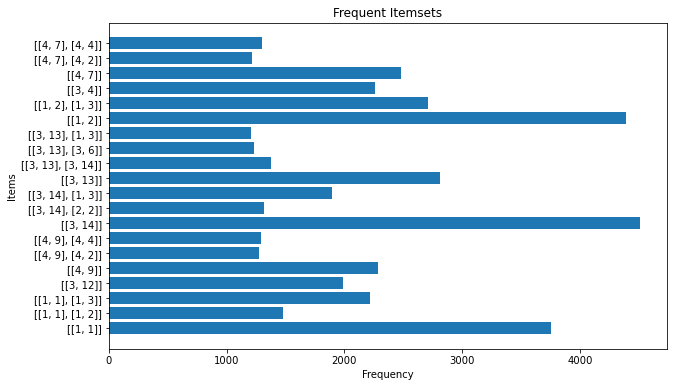

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = [
    ([[1, 1]], 3749),
    ([[1, 1], [1, 2]], 1478),
    ([[1, 1], [1, 3]], 2214),
    ([[3, 12]], 1989),
    ([[4, 9]], 2288),
    ([[4, 9], [4, 2]], 1271),
    ([[4, 9], [4, 4]], 1294),
    ([[3, 14]], 4510),
    ([[3, 14], [2, 2]], 1318),
    ([[3, 14], [1, 3]], 1893),
    ([[3, 13]], 2807),
    ([[3, 13], [3, 14]], 1373),
    ([[3, 13], [3, 6]], 1231),
    ([[3, 13], [1, 3]], 1207),
    ([[1, 2]], 4387),
    ([[1, 2], [1, 3]], 2712),
    ([[3, 4]], 2256),
    ([[4, 7]], 2476),
    ([[4, 7], [4, 2]], 1219),
    ([[4, 7], [4, 4]], 1300)
]

# Convert data to Pandas DataFrame
df = pd.DataFrame(data, columns=['items', 'freq'])

# Plot frequent itemsets
plt.figure(figsize=(10, 6))
plt.barh(range(len(df)), df['freq'], tick_label=[str(item) for item in df['items']])
plt.xlabel('Frequency')
plt.ylabel('Items')
plt.title('Frequent Itemsets')
plt.show()


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


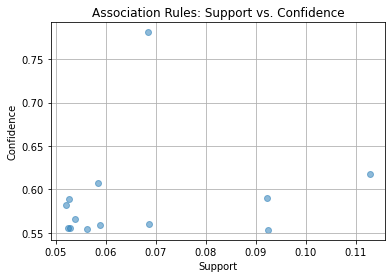

In [8]:
import matplotlib.pyplot as plt

# Extract support and confidence from the association rules DataFrame
support = model.associationRules.select("support").rdd.map(lambda row: row[0]).collect()
confidence = model.associationRules.select("confidence").rdd.map(lambda row: row[0]).collect()

# Visualize support vs. confidence as a scatter plot
plt.scatter(support, confidence, alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs. Confidence')
plt.grid(True)
plt.show()

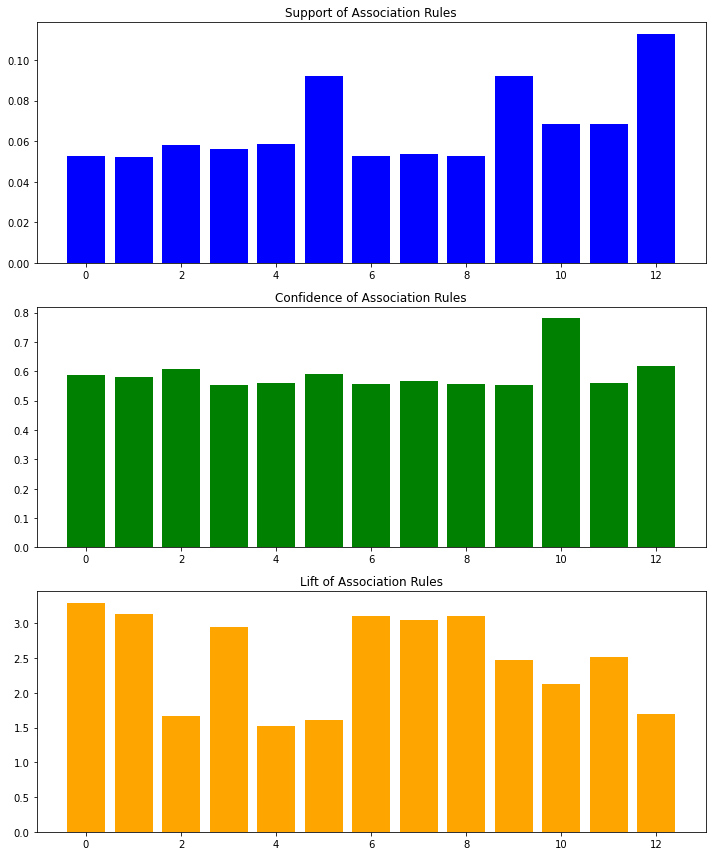

In [9]:
import matplotlib.pyplot as plt

# Extract support, confidence, and lift from the association rules DataFrame
support = model.associationRules.select("support").rdd.map(lambda row: row[0]).collect()
confidence = model.associationRules.select("confidence").rdd.map(lambda row: row[0]).collect()
lift = model.associationRules.select("lift").rdd.map(lambda row: row[0]).collect()

# Create bar charts for support, confidence, and lift
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

axs[0].bar(range(len(support)), support, color='blue')
axs[0].set_title('Support of Association Rules')

axs[1].bar(range(len(confidence)), confidence, color='green')
axs[1].set_title('Confidence of Association Rules')

axs[2].bar(range(len(lift)), lift, color='orange')
axs[2].set_title('Lift of Association Rules')

plt.tight_layout()
plt.show()


In [10]:
import seaborn as sns

# Convert association rules DataFrame to Pandas DataFrame
rules_df = model.associationRules.toPandas()




/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


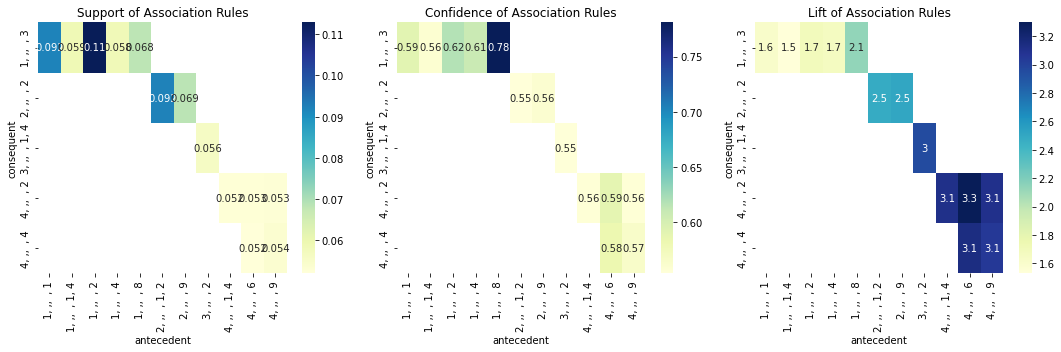

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert lists in 'antecedent' and 'consequent' columns to strings
rules_df['antecedent'] = rules_df['antecedent'].apply(lambda x: ', '.join(map(str, np.ravel(x))))
rules_df['consequent'] = rules_df['consequent'].apply(lambda x: ', '.join(map(str, np.ravel(x))))


# Convert lists in 'antecedent' and 'consequent' columns to strings
rules_df['antecedent'] = rules_df['antecedent'].apply(lambda x: ', '.join(x))
rules_df['consequent'] = rules_df['consequent'].apply(lambda x: ', '.join(x))

# Create heatmaps for support, confidence, and lift
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(rules_df.pivot("consequent", "antecedent", "support"), ax=axs[0], cmap="YlGnBu", annot=True)
axs[0].set_title('Support of Association Rules')

sns.heatmap(rules_df.pivot("consequent", "antecedent", "confidence"), ax=axs[1], cmap="YlGnBu", annot=True)
axs[1].set_title('Confidence of Association Rules')

sns.heatmap(rules_df.pivot("consequent", "antecedent", "lift"), ax=axs[2], cmap="YlGnBu", annot=True)
axs[2].set_title('Lift of Association Rules')

plt.tight_layout()
plt.show()


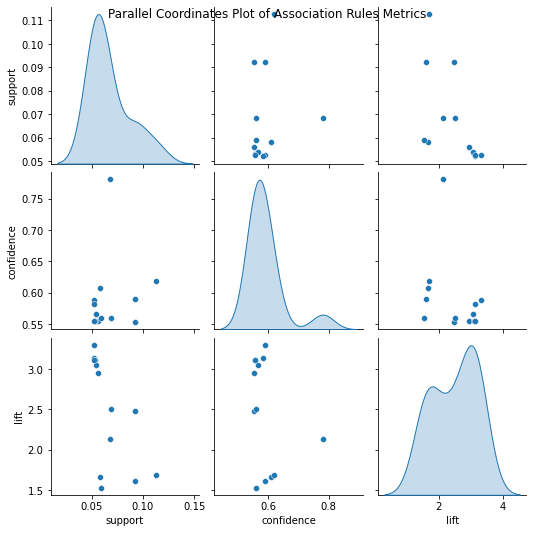

In [12]:
import seaborn as sns

# Create parallel coordinates plot for support, confidence, and lift
sns.pairplot(rules_df[['support', 'confidence', 'lift']], diag_kind='kde')
plt.suptitle("Parallel Coordinates Plot of Association Rules Metrics")
plt.show()

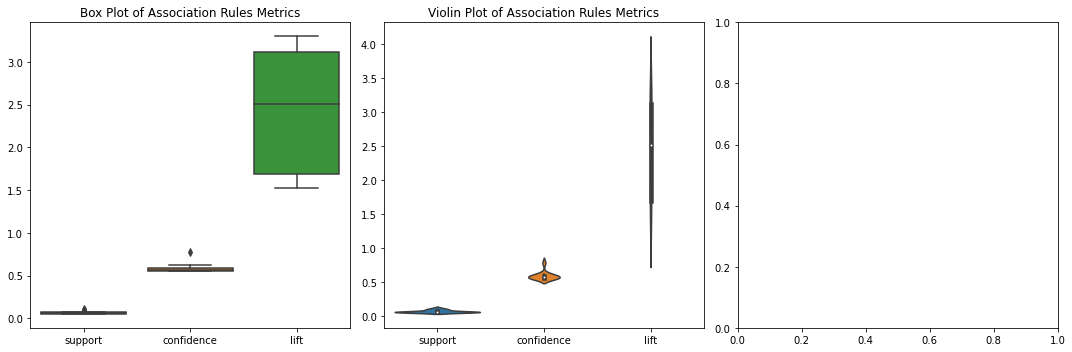

In [13]:
# Create box plot or violin plot for support, confidence, and lift
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=rules_df[['support', 'confidence', 'lift']], ax=axs[0])
axs[0].set_title('Box Plot of Association Rules Metrics')

sns.violinplot(data=rules_df[['support', 'confidence', 'lift']], ax=axs[1])
axs[1].set_title('Violin Plot of Association Rules Metrics')

plt.tight_layout()
plt.show()